In [1]:
import random
import networkx as nx
from matplotlib import pyplot as plt
from collections import Counter
import math
from utils.plotTools import plot_qwak
import os
import ast

In [25]:
def load_list_from_file(file_path):
    with open(file_path, 'r') as file:
        data_str = file.read()
    data = [json.loads(line) for line in data_str.splitlines()]
    return data


def write_list_to_file(file_path, data):
    data_str = [str(item) for item in data]  # Convert float values to strings
    with open(file_path, 'w') as file:
        file.write('\n'.join(data_str))
        
def load_or_generate_data(file1, file2, generation_func1, generation_func2, args1=(), kwargs1={}, args2=(), kwargs2={}):
    """
    Load data from files if they exist, or generate data using specified functions.
    
    :param file1: the file path to load the first data from
    :param file2: the file path to load the second data from
    :param generation_func1: the function to generate the first data if the file doesn't exist
    :param generation_func2: the function to generate the second data if the file doesn't exist
    :param args1: tuple containing positional arguments for the first generation function
    :param kwargs1: dict containing keyword arguments for the first generation function
    :param args2: tuple containing positional arguments for the second generation function
    :param kwargs2: dict containing keyword arguments for the second generation function
    :return: a tuple containing the two datasets
    """
    
    if os.path.exists(file1) and os.path.exists(file2):
        data1 = load_list_from_file(file1)
        data2 = load_list_from_file(file2)
        print('Files exist!')
    else:
        print('Files do not exist, generating data...')
        data1 = generation_func1(*args1, **kwargs1)
        data2 = generation_func2(*args2, **kwargs2)
        
        if not os.path.exists(file1):
            write_list_to_file(file1, data1)
            
        if not os.path.exists(file2):
            write_list_to_file(file2, data2)
    
    return data1, data2

# Sisyphus wheel

In [3]:
def create_sisyphus_wheel(n, t):
    """
    Create a Sisyphus wheel graph with self-loops for a given time step.

    Parameters:
    n (int): The number of nodes in the graph.
    t (int): The time step.

    Returns:
    G (networkx.Graph): The Sisyphus wheel graph with self-loops at time step t.
    """

    # Create an empty graph
    G = nx.Graph()

    # Add nodes
    G.add_nodes_from(range(1, n + 1))

    # Determine the central node
    central_node = 1 + (-t % (n - 1))

    # Add edges from all nodes to the central node and self-loops to non-central nodes
    for i in range(1, n + 1):
        if i != central_node:
            G.add_edge(i, central_node)
            G.add_edge(i, i)  # Add a self-loop

    return G



def plot_cover_time(n_range, cover_times_by_size):
    # Plot the cover times
    plt.plot(n_range, cover_times_by_size, marker='o', label='Average Cover Time')
    
    # Plot 2^(number of nodes)
    exponential_values = [2**n for n in n_range]
    plt.plot(n_range, exponential_values, marker='x', linestyle='--', label='2^(Number of Nodes)')
    
    # Labels and title
    plt.xlabel('Number of Nodes')
    plt.ylabel('Average Cover Time')
    plt.title('Cover Time of Sisyphus Wheel Graphs vs 2^(Number of Nodes)')
    
    # Add a legend to the plot
    plt.legend()
    
    # Grid
    plt.grid(True)
    
    # Show plot
    plt.show()


def sisyphus_graph_cover_time(n_range):
    cover_times = []
    for n in n_range:
        cover_times.append(2**n)
    return cover_times

def generate_sisyphus_wheels(n_range, num_time_steps):
    """
    Generate Sisyphus wheel graphs for a range of n values and a number of time steps.

    Parameters:
    n_range (iterable): Range of n values representing the number of nodes.
    num_time_steps (int): Number of time steps for each graph.

    Returns:
    List of lists of networkx.Graph: Each inner list contains Sisyphus wheel graphs
                                     for a specific n value at different time steps.
    """
    sisyphus_wheels = []
    
    for n in n_range:
        sisyphus_wheels_n = []
        for t in range(num_time_steps):
            sisyphus_wheels_n.append(create_sisyphus_wheel(n, t))
        sisyphus_wheels.append(sisyphus_wheels_n)
    
    return sisyphus_wheels

def estimate_multiple_cover_time_evolving(evolving_graphs, num_simulations=1000):
    """
    Estimate the cover time of a list of evolving graphs.

    Parameters:
    evolving_graphs (list of lists): A list of sequences of graphs representing the evolving graphs.
    num_simulations (int): The number of simulations to perform.

    Returns:
    cover_times (list): A list of estimated cover times for each evolving graph.
    """

    cover_times = []

    for evolving_graph in evolving_graphs:
        total_steps_for_all_simulations = 0

        for _ in range(num_simulations):
            visited = set()
            start_node = random.choice(list(evolving_graph[0].nodes))
            current_node = start_node
            total_steps_this_simulation = 0

            # Loop continues until all nodes are visited
            while len(visited) < len(evolving_graph[0].nodes):
                # Get the graph at the current time step (evolving with time)
                t = total_steps_this_simulation % len(evolving_graph)
                graph = evolving_graph[t]

                # Choose a neighbor randomly
                neighbors = list(nx.neighbors(graph, current_node))
                if neighbors:
                    current_node = random.choice(neighbors)
                    
                # Add the current_node to visited if not already present
                if current_node not in visited:
                    visited.add(current_node)
                
                total_steps_this_simulation += 1

            # Accumulate the total steps for this simulation
            total_steps_for_all_simulations += total_steps_this_simulation

        # Average the total steps over the number of simulations
        average_cover_time = total_steps_for_all_simulations / num_simulations
        cover_times.append(average_cover_time)

    return cover_times

In [4]:
def draw_sisyphus_wheel(graph, t):
    """
    Draw a Sisyphus wheel graph at a given time step.

    Parameters:
    graph (networkx.Graph): The Sisyphus wheel graph.
    t (int): The time step.
    """
    pos = nx.spring_layout(graph)
    plt.figure(figsize=(6, 6))
    nx.draw(graph, pos, with_labels=True, node_size=800, node_color='skyblue')
    plt.title(f'Sisyphus Wheel Graph at Time Step {t}')
    plt.show()


# Parameters
num_nodes = 6
time_steps = [0, 1, 2, 3, 4, 5,6]

# Iterating through time steps and drawing the graph
# for t in time_steps:
#     sisyphus_wheel = create_sisyphus_wheel(num_nodes, t)
#     draw_sisyphus_wheel(sisyphus_wheel, t)

In [5]:
def estimate_dynamic_cover_time(n_range, num_simulations=1000):
    """
    Estimate the cover time of a list of evolving Sisyphus wheel graphs.

    Parameters:
    n_range (range): Range of number of nodes in the graph.
    num_simulations (int): The number of simulations to perform.

    Returns:
    cover_times (list): A list of estimated cover times for each evolving graph.
    """

    cover_times = []

    for n in n_range:
        total_steps_for_all_simulations = 0
        print(f'\nCalculatig cover time for n = {n}')
        for s in range(num_simulations):
            
            if s==0 or s==1 or s==10 or s==25 or s==35 or s==49:
                print(f'----> Sample number:{s}')
                
            visited = set()
            current_node = random.choice(range(1, n+1))
            total_steps_this_simulation = 0
            visited.add(current_node)

            # Loop continues until all nodes are visited
            while len(visited) < n:
                # Get the graph at the current time step (evolving with time)
                graph = create_sisyphus_wheel(n, total_steps_this_simulation)
                # Choose a neighbor randomly
                neighbors = list(nx.neighbors(graph, current_node))
                if neighbors:
                    current_node = random.choice(neighbors)
                    
                # Add the current_node to visited if not already present
                if current_node not in visited:
                    visited.add(current_node)
                
                total_steps_this_simulation += 1

            # Accumulate the total steps for this simulation
            total_steps_for_all_simulations += total_steps_this_simulation

        # Average the total steps over the number of simulations
        average_cover_time = total_steps_for_all_simulations / num_simulations
        cover_times.append(average_cover_time)

    return cover_times

In [15]:
n_range = range(5, 20)
samples = 50
max_timesteps = 5

cover_times_sisyphus_wheel_file = f'Datasets/DynGraphsDTRW/coverTimeSisyphus_N{n_range[-1]}_T{max_timesteps}_S{samples}.txt'
estimate_sisyphus_cover_time_file = f'Datasets/DynGraphsDTRW/estimateTimeSisyphus_N{n_range[-1]}_T{max_timesteps}_S{samples}.txt'

if os.path.exists(cover_times_sisyphus_wheel_file) and os.path.exists(estimate_sisyphus_cover_time_file):
    cover_times_sisyphus_wheel = load_list_from_file(cover_times_sisyphus_wheel_file)
    estimate_sisyphus_cover_time = load_list_from_file(estimate_sisyphus_cover_time_file)
    print('File exists!')
else:
    print('File Doesnt Exist!')
    cover_times_sisyphus_wheel = estimate_dynamic_cover_time(n_range, num_simulations=samples)
    estimate_sisyphus_cover_time = sisyphus_graph_cover_time(n_range)
    if not os.path.exists(cover_times_sisyphus_wheel_file):
        write_list_to_file(cover_times_sisyphus_wheel_file, cover_times_sisyphus_wheel)
    if not os.path.exists(estimate_sisyphus_cover_time_file):
        write_list_to_file(estimate_sisyphus_cover_time_file, estimate_sisyphus_cover_time)


File exists!


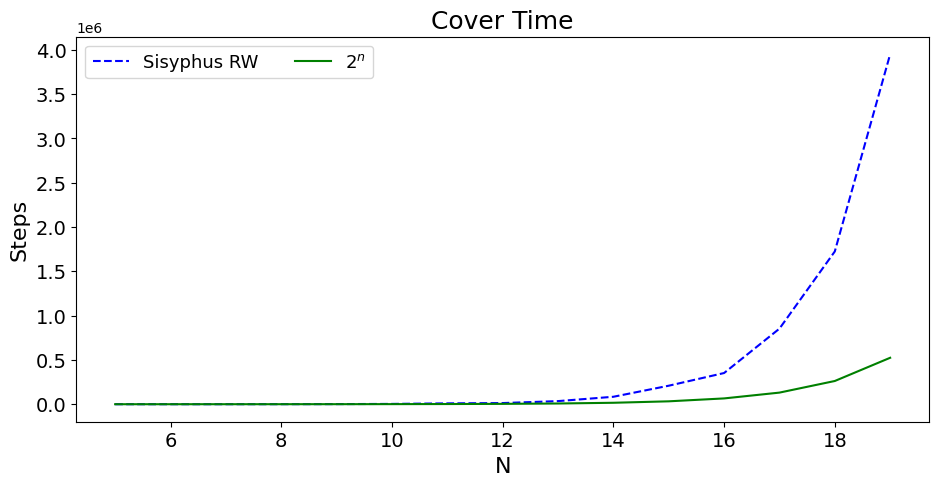

In [16]:
alphaLabelList = [r'Sisyphus RW',r'$2^{n}$']

params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Cover Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 3,
    'color_list' : ['#0000FF', '#008000', '#525252'],
    'line_style_list' : ['--', '-','-.' ],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    # 'x_num_ticks' : 7,
    # 'y_num_ticks' : 7,
    # 'x_round_val' : 1,
    # 'y_round_val' : 3,
}

node_value_matrix = list(n_range)
plot_qwak(x_value_matrix = [node_value_matrix,node_value_matrix] , y_value_matrix = [cover_times_sisyphus_wheel,estimate_sisyphus_cover_time],**params)